In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
import statsmodels.api as smm
import sympy as sym
from datetime import datetime as DT
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
from cftime import date2num
from tqdm.notebook import tqdm
# Interactive plots
%matplotlib widget 
from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# Figure output
figdir = os.path.join(pc_root, 'Article_figures')
# nc file output
outdir = os.path.join(pc_root, 'Bicoherence')
sig_specdir = os.path.join(pc_root, 'Spectra_ENU')
# Check if outdir exists and if not create it
if not os.path.isdir(outdir):
    os.mkdir(outdir)
# Signature 1000 ADCP data
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Vector ADCP data
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

# Start/end dates/times of experiment period
t0 = pd.Timestamp('2022-06-27 00:00') # Start date
t1 = pd.Timestamp('2022-07-14 10:00') # End date
# Make hourly time array
date_range = pd.date_range(t0, t1, freq='1D')

# Experiment vs. paper mooring IDs (Signatures and Vectors)
sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'}
vec_mids = {'C2':'VO', 'C3':'VM', 'C5':'VI', 'L1':'VS', 'L5':'VN'}

# Default Signature and Vector mooring ID colors
clss = {'C1':'#a70000', 'C3':'#ff5252', 'C6':'#ffbaba', 'L5':'gold'}
clsv = {'C2':'#0A369D', 'C3':'#92B4F4', 'C5':'#CFDEE7', 'L5':'darkturquoise'}

# Vector bursts to skip due to noisy data despite despiking (manually checked)
vec_skip = {'L1':[pd.Timestamp('2022-07-01 12:00:00'),
                  pd.Timestamp('2022-07-02 20:00:00'),
                  pd.Timestamp('2022-07-03 14:00:00'),
                  pd.Timestamp('2022-07-04 13:00:00'),
                  pd.Timestamp('2022-07-04 14:00:00'),
                  pd.Timestamp('2022-07-04 15:00:00'),
                  pd.Timestamp('2022-07-11 10:00:00'),
                  pd.Timestamp('2022-07-17 05:00:00'),
                  ],
            'L5':[pd.Timestamp('2022-07-02 19:00:00'),
                  ],
            'C2':[],
            'C3':[],
            'C5':[],
            }
# Reference date for netcdf timestamps
ref_date=pd.Timestamp('2000-01-01')

# Main loop to iterate over dates and desired moorings
dfv_dict = {} # Dict for Vector Urms/mean(w) dataframes 
for mid in ['C2', 'C3', 'C5']:
    print(f'Getting {mid} Vec Urms...')
    # Check if dataframe already saved to csv
    fn_urms_csv = os.path.join(vec_root, 'Urms_csv', f'{mid}_urms_v2.csv')
    if os.path.isfile(fn_urms_csv):
        dfi = pd.read_csv(fn_urms_csv, parse_dates=['time']).set_index('time')
    # Add complete dataframe to dict
    dfv_dict[mid] = dfi

/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Getting C2 Vec Urms...
Getting C3 Vec Urms...
Getting C5 Vec Urms...


Estimate hourly bicoherence and concatenate to daily files.

In [95]:
# Estimate bicoherence for Sig surface elevation and Vec u for sample period
for i, (mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    print(f'Signature {mid}-{ser}')
    # Output netcdf filename
    fn_out = os.path.join(outdir, 'bicoherence_biphase_sig_{}.nc'.format(mid))
    if not os.path.isfile(fn_out):
        # Empty list for hourly bicoherence datasets for current date (for concatenating)
        bcl = []
        # Iterate over dates
        for d0 in tqdm(date_range):
            # Make hourly range array for current date
            time_range = pd.date_range(d0, d0+pd.Timedelta(days=1), freq='1h')[:-1]
            # Iterate over 1h segments
            for t0b in time_range:
                t1b = t0b + pd.Timedelta(hours=1) # Sample period end
                if t0b > t1:
                    # Don't go beyond end of experiment
                    continue
                # Read Signature velocity dataset
                sigdir = os.path.join(sig_root, '{}'.format(ser))
                fn_sig = os.path.join(sigdir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(
                    mid, str(t0b.date().strftime('%Y%m%d'))))
                dss = xr.open_dataset(fn_sig, decode_coords='all')
                # Take out burst segment
                segs = dss.sel(time=slice(t0b, t1b)).copy()
                depth = dss.z_hyd.mean().item()

                # Parameters for Gaussian filter
                sigma = 2
                winsz = 5
                truncate = (((winsz - 1)/2)-0.5)/sigma
                # Bicoherence
                _, dbcs = rpws.bispectrum(segs.ASTd_eta.values, fs=4, fmerge=3, wsec=128,
                                        return_bicoh=True, return_krms=False)
                # Compute the biphase following Elgar and Guza (1985)
                br = np.real(dbcs.B.values)
                bi = np.imag(dbcs.B.values)
                brf = gaussian_filter(br, sigma=sigma, truncate=truncate)
                bif = gaussian_filter(bi, sigma=sigma, truncate=truncate)
                bp = np.arctan2(bif, brf) # Biphase
                # Add filtered array to dataset
                dbcs['bp'] = (['freq1', 'freq2'], bp)
                # Remove (complex) bispectrum array from dataset
                vars_to_keep = ['Bc', 'bp', 'dof', 'b99', 'b95', 'b90', 'b80']
                dbcs = dbcs[vars_to_keep]
                # Apply Gaussian filter to bicoherence
                bc = dbcs.Bc.values
                bc[bc < dbcs.b99.item()] = 0 # Set to zero values < 99% confidence int.
                bg = gaussian_filter(bc**2, sigma=sigma, truncate=truncate) # Filter bicoherence
                # bg = gaussian_filter(bc, sigma=sigma, truncate=truncate) # Filter bicoherence
                # Add filtered array to dataset
                dbcs['bcf'] = (['freq1', 'freq2'], bg)
                # Replace 'raw' bicoherence with unfiltered Bc**2
                dbcs['bc'] = (['freq1', 'freq2'], dbcs.Bc.values**2)
                vars_to_keep = ['bc', 'bcf', 'bp', 'dof', 'b99', 'b95', 'b90', 'b80']
                dbcs = dbcs[vars_to_keep]

                # Add time coordinate to dataset
                # Convert time array to numerical format
                time_units = 'seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
                time = pd.to_datetime(t0b).to_pydatetime()
                time_vals = date2num(time, 
                                    time_units, calendar='standard', 
                                    has_year_zero=True)
                dbcs.coords['time'] = time_vals.astype(float)
                dbcs.time.encoding['units'] = time_units
                dbcs.time.attrs['units'] = time_units
                dbcs.time.attrs['standard_name'] = 'time'
                dbcs.time.attrs['long_name'] = 'Local time (PDT) of bispectral segment start'

                # Append dataset to list for daily concatenating
                bcl.append(dbcs)
            
        # Concatenate daily bicoherence datasets for current Signature
        print('Concatenating and saving bicoherence arrays ... \n')
        dsb = xr.concat(bcl, dim='time')
        # Save to netcdf
        dsb.to_netcdf(fn_out)




# Vector ucs-bicoherence
for i, (mid,ser) in enumerate(zip(['C2', 'C3', 'C5'], ['17212', '17219', '17372'])):
    print(f'Vector {mid}-{ser}')
    # Output netcdf filename
    fn_out = os.path.join(outdir, 'bicoherence_biphase_vec_{}.nc'.format(mid))
    if not os.path.isfile(fn_out):
        # Empty list for hourly bicoherence datasets for current date (for concatenating)
        bcl = []
        # Iterate over dates
        for d0 in tqdm(date_range):
            # Make hourly range array for current date
            time_range = pd.date_range(d0, d0+pd.Timedelta(days=1), freq='1h')[:-1]
            # Iterate over 1h segments
            for t0b in time_range:
                t1b = t0b + pd.Timedelta(hours=1) # Sample period end
                if t0b > t1:
                    # Don't go beyond end of experiment
                    continue
                # Read Vector netcdf file
                ncdir = os.path.join(vec_root, mid)
                fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
                    str(t0b.date().strftime('%Y%m%d'))))
                dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
                # Select sample period
                seg = dsv.sel(time=slice(t0b, t1b))
                # Check for fraction of spikes in Vector burst
                spikes_frac_x = np.sum(~np.isclose(seg.ux, seg.uxd)) / len(seg.uz)
                spikes_frac_y = np.sum(~np.isclose(seg.uy, seg.uyd)) / len(seg.uz)
                spikes_frac_z = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
                # Max fraction of spikes = 0.2
                if spikes_frac_x>0.2 or spikes_frac_y>0.2 or spikes_frac_z>0.2:
                    continue
                # Check if burst should be skipped due to manual inspection
                if t0b in vec_skip[mid]:
                    continue
                # Get sea-surface elevation (K_rms transform)
                eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
                depth = seg.z_hyd.mean().item() # water depth
                # Convert velocities to cross-/alongshore
                if mid in ['L1', 'L5']:
                    # x vel, despiked
                    uxd = seg.uxd.to_dataframe() # Convert to pandas
                    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                    uxm = uxd.mean().item()
                    uxd -= uxm # Remove mean
                    # uxd -= uxm
                    # y vel, despiked
                    uyd = seg.uyd.to_dataframe() # Convert to pandas
                    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                    uym = uyd.mean().item()
                    uyd -= uym # Remove mean
                    # uyd -= uym
                    # z vel, despiked
                    uzd = seg.uzd.to_dataframe() # Convert to pandas
                    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                    uzm = uzd.mean().item()
                    uzd -= uzm # Remove mean
                    # uzd -= uzd.mean()
                    # Rotate velocities to cross/alongshore & vertical using PCA
                    ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                    uy=uyd.values.squeeze(), 
                                                    uz=uzd.values.squeeze(),
                                                    # print_msg=True,
                                                    )
                    # Check that ucs is in the right (shoreward) direction by computing 
                    # mean wave direction from directional wave spectrum
                    dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
                    # If mdir close to 90 deg -> flip velocities
                    if abs(dssu.mdir.item() - 270) > 90:
                        ucs *= (-1)
                        uls *= (-1)
                        uw *= (-1)
                else:
                    # Convert E,N velocities to local cross- & alongshore 
                    uE = seg.uE.to_dataframe() # Convert to pandas
                    uE = uE.interpolate(method='bfill').interpolate('ffill')
                    uE -= uE.mean() # Remove mean
                    uN = seg.uN.to_dataframe() # Convert to pandas
                    uN = uN.interpolate(method='bfill').interpolate('ffill')
                    uN -= uN.mean() # Remove mean
                    uU = seg.uU.to_dataframe() # Convert to pandas
                    uU = uU.interpolate(method='bfill').interpolate('ffill')
                    dss_seg = rpws.spec_uvz(z=eta.values, 
                                            u=uE.values.squeeze(), 
                                            v=uN.values.squeeze(), 
                                            fs=16,
                                            fmerge=5,
                                            )
                    # Convert to cross-alongshore based on mean wave direction
                    angle_met = dss_seg.mdir.item() # Cross-shore angle
                    angle_math = 270 - angle_met # Math angle to rotate
                    if angle_math < 0:
                        angle_math += 360
                    angle_math = np.deg2rad(angle_math) # Radians
                    # Rotate East and North velocities to cross-shore (cs) and 
                    # long-shore (ls)
                    ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                            uN.values.squeeze(), 
                                            angle_math,
                                            )
                    uw = uU.values.squeeze() # Vertical vel.
                # Bicoherence (downsample to 4Hz and average)
                bca = [] # Empty list for averaging downsampled bicoherence arrays
                bpa = [] # Empty list for averaging downsampled biphase arrays
                for di in range(4):
                    _, dbcv = rpws.bispectrum(ucs[di::4], fs=4, fmerge=3, wsec=128,
                                              return_bicoh=True, return_krms=False)
                    # Compute the biphase following Elgar and Guza (1985)
                    bp = np.arctan2(np.imag(dbcv.B.values), np.real(dbcv.B.values))
                    bpf = gaussian_filter(bp, sigma=sigma, truncate=truncate) # Filter biphase
                    # Append to list for avging
                    bpa.append(bp)
                    # Set to zero non-significant values of bicoherence
                    bc = dbcv.Bc.values # array format
                    bc[bc < dbcv.b99.item()] = 0 # Set to 0 values < 99% significance
                    # Append to list for avging
                    bca.append(bc)
                # Average bicoherence & biphase
                bc = np.array(bca).mean(axis=0)
                bp = np.array(bpa).mean(axis=0)
                # Filter
                bg = gaussian_filter(bc**2, sigma=sigma, truncate=truncate)
                bpf = gaussian_filter(bp, sigma=sigma, truncate=truncate)
                # Add filtered arrays to dataset
                dbcv['bcf'] = (['freq1', 'freq2'], bg**2)
                dbcv['bp'] = (['freq1', 'freq2'], bpf)
                # Replace 'raw' bicoherence with unfiltered Bc**2
                dbcv['bc'] = (['freq1', 'freq2'], dbcv.Bc.values**2)
                vars_to_keep = ['bc', 'bcf', 'bp', 'dof', 'b99', 'b95', 'b90', 'b80']
                dbcv = dbcv[vars_to_keep]

                # Add time coordinate to dataset
                # Convert time array to numerical format
                time_units = 'seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
                time = pd.to_datetime(t0b).to_pydatetime()
                time_vals = date2num(time, 
                                     time_units, calendar='standard', 
                                     has_year_zero=True,
                                     )
                dbcv.coords['time'] = time_vals.astype(float)
                dbcv.time.encoding['units'] = time_units
                dbcv.time.attrs['units'] = time_units
                dbcv.time.attrs['standard_name'] = 'time'
                dbcv.time.attrs['long_name'] = 'Local time (PDT) of bispectral segment start'

                # Append dataset to list for daily concatenating
                bcl.append(dbcv)

        # Concatenate daily bicoherence datasets for current Signature
        print('Concatenating and saving bicoherence arrays for Vectors ... \n')
        dsb = xr.concat(bcl, dim='time')
        # Save to netcdf
        dsb.to_netcdf(fn_out)


Signature C1-103088
Signature C3-103094
Signature C6-103110


  0%|          | 0/18 [00:00<?, ?it/s]

Concatenating and saving bicoherence arrays ... 

Vector C2-17212


  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [110]:
df_sig = {} # Empty dict to store Signature bicoh vs fp dataframes
for i, (mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    print(f'Signature {mid}-{ser}')
    # Bicoherence netcdf filename
    fn = os.path.join(outdir, 'bicoherence_biphase_sig_{}.nc'.format(mid))
    dsb = xr.open_dataset(fn, decode_coords='all')
    # Signature spectral netcdf (at C1)
    fn_spec = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103088_spec_AST_ENU.nc'.format(
        ser))
    dss = xr.open_dataset(fn_spec, decode_coords='all')
    bp_sw = [] # List for bicoh values around fp, 2 swell systems
    bp_ws = [] # List for bicoh values around fp, primary swell + windsea
    bp2_sw = [] # List for bicoh values around fp*2, 2 swell systems
    bp2_ws = [] # List for bicoh values around fp*2, swell1 + windsea
    bp12 = [] # List for bicoh values around fp1 + 2*fp2
    bp21 = [] # List for bicoh values around 2*fp1 + fp2
    bps_sw = [] # List for bicoh values around fp1-fp2, 2 swell systems
    bps_ws = [] # List for bicoh values around fp1-fp2, swell1 + windsea
    ph_fp = [] # Biphase at self interaction of fp
    ts = [] # List for timestamps
    hs = [] # List for Hs
    d = [] # List for depths
    ur = [] # List for Ursell numbers
    kp = [] # List for kp
    dfs_sw = [] # List for difference frequencies b/w primary-swcondary swell peak freqs
    dfs_ws = [] # List for difference frequencies b/w primary swell & windsea peak freqs
    hsr_sw = [] # List for ratio of hs of primary/secondary swell
    hsr_ws = [] # List for ratio of hs of primary swell / windsea
    sk = [] # Skewness
    # Iterate over hours in bicoherence dataset
    for t0s in dsb.time.values:
        if t0s < pd.Timestamp('2022-06-24 12:00'):
            continue
        # Get current peak freq from spectrum
        fp = dss.fp.sel(time=t0s).values.item()
        # Find nearest bicoherence frequency to fp
        absf1 = np.abs(dsb.freq1-fp)
        absf2 = np.abs(dsb.freq2-fp)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        # Compute avg bicoherence around fp 
        bc_fp = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])

        # Sub/super harmonics
        fp1 = dss.fp_swell1.sel(time=t0s).values.item() # Primary swell fp
        if np.isnan(fp1):
            # Use full-spectrum fp
            fp1 = dss.fp.sel(time=t0s).values.item()
        hs2 = dss.Hm0_swell2.sel(time=t0s).values.item() # Secondary swell Hs
        hsw = dss.Hm0_windsea.sel(time=t0s).values.item() # Secondary swell Hs
        if hs2 > hsw:
            # Use secondary swell as other peak
            swell = True # Flag
            windsea = False
            fp2 = dss.fp_swell2.sel(time=t0s).values.item() # Secondary swell fp
        elif hs2 < hsw:
            swell = False # Flag
            windsea = True # Flag
            # Use windsea peak as other peak
            fp2 = dss.fp_windsea.sel(time=t0s).values.item() # Windsea fp
        else:
            swell = False # Flag
            windsea = True # Flag
            # Equal Hs from swell2 and windsea -> use swell2
            fp2 = dss.fp_swell2.sel(time=t0s).values.item() # Secondary swell fp
        # Compute subharmonic b/w fp1-fp2
        fsub = abs(fp1-fp2) # Subharmonic of primary-secondary swell
        if not np.isnan(fsub):
            absf1 = np.abs(dsb.freq1-fp1)
            absf2 = np.abs(dsb.freq2-fsub)
            c = np.maximum(absf1, absf2)
            f1 = c.argmin(dim=['freq1', 'freq2'])['freq1'].item()
            f2 = c.argmin(dim=['freq1', 'freq2'])['freq2'].item()
            bc_sfp = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
            bc_sfp = bc_sfp.values.item()
        else:
            bc_sfp = np.nan

        # Find nearest bicoherence frequency to fp1+fp2
        absf1 = np.abs(dsb.freq1-(fp1+fp2))
        absf2 = np.abs(dsb.freq2-(fp1+fp2))
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest 2*fp inds
        # Compute avg bicoherence around 2*fp
        bc_2fp = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        bc_2fp = bc_2fp.values.item()

        # Find nearest bicoherence frequency to fp1 + 2*fp2
        absf1 = np.abs(dsb.freq1-(fp1+fp2*2))
        absf2 = np.abs(dsb.freq2-(fp1+fp2*2))
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest 3*fp inds
        # Compute avg bicoherence around 3*fp
        bc_12 = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])

        # Find nearest bicoherence frequency to 2*fp1 + fp2
        absf1 = np.abs(dsb.freq1-(fp1*2+fp2))
        absf2 = np.abs(dsb.freq2-(fp1*2+fp2))
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest 3*fp inds
        # Compute avg bicoherence around 3*fp
        bc_21 = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])

        # Biphase for self interaction at fp
        fp = dss.fp.sel(time=t0s).values.item()
        # Find nearest bicoherence frequency to fp
        absf1 = np.abs(dsb.freq1-fp)
        absf2 = np.abs(dsb.freq2-fp)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        bph_fp = dsb.bp.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        # Find nearest bicoherence frequency to 2*fp
        absf1 = np.abs(dsb.freq1-2*fp)
        absf2 = np.abs(dsb.freq2-2*fp)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        bph_2fp = dsb.bp.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        # Biphase at self-interaction, see eg Elgar & Guza (1985) or Holthuijsen, p. 273
        beta_fp = np.rad2deg(2*bph_fp - bph_2fp)

        # Append to list
        ph_fp.append(beta_fp)
        bp12.append(bc_12.values.item())
        bp21.append(bc_21.values.item())
        if swell:
            bp_sw.append(bc_fp)
            bp_ws.append(np.nan)
            bp2_sw.append(bc_2fp)
            bp2_ws.append(np.nan)
            bps_sw.append(bc_sfp)
            bps_ws.append(np.nan)
            dfs_sw.append(fsub) # Difference b/w primary-secondary swell peaks
            dfs_ws.append(np.nan)
        elif windsea:
            bp_ws.append(bc_fp)
            bp_sw.append(np.nan)
            bp2_ws.append(bc_2fp)
            bp2_sw.append(np.nan)
            bps_ws.append(bc_sfp)
            bps_sw.append(np.nan)
            dfs_ws.append(fsub) # Difference b/w primary-secondary swell peaks
            dfs_sw.append(np.nan)

        # Append other things from spectrum
        hs.append(dss.Hm0.sel(time=t0s).item())
        kp.append(dss.kp.sel(time=t0s).item())
        d.append(dss.depth_loc.sel(time=t0s).item())
        u_nom = 9.81 * dss.Hm0.sel(time=t0s).item() * (1/dss.fp.sel(time=t0s).item())**2
        u_denom = 8 * np.sqrt(2) * np.pi**2 * dss.depth_loc.sel(time=t0s).item()**2
        ur.append(u_nom / u_denom)
        sk.append(dss.skew.sel(time=t0s).item())
        hs1 = dss.Hm0_swell1.sel(time=t0s).item()
        hs2 = dss.Hm0_swell2.sel(time=t0s).item()
        if hs2 == 0:
            # No secondary swell -> use windsea instead
            hs2 = dss.Hm0_windsea.sel(time=t0s).item()
        if hs2 > 0:
            if swell:
                hsr_sw.append(hs1 / hs2)
                hsr_ws.append(np.nan)
            elif windsea:
                hsr_ws.append(hs1 / hs2)
                hsr_sw.append(np.nan)
        else:
            if swell:
                hsr_sw.append(0)
                hsr_ws.append(np.nan)
            if windsea:
                hsr_ws.append(0)
                hsr_sw.append(np.nan)
        # Append timestamp
        ts.append(pd.Timestamp(t0s))
    # Convert lists to np.array
    bp_sw = np.array(bp_sw)
    bp_ws = np.array(bp_ws)
    bps_sw = np.array(bps_sw)
    bps_ws = np.array(bps_ws)
    ph_fp = np.array(ph_fp)
    hs = np.array(hs)
    sk = np.array(sk)
    kp = np.array(kp)
    d = np.array(d)
    ur = np.array(ur)
    dfs_sw = np.array(dfs_sw)
    dfs_ws = np.array(dfs_ws)
    hsr_sw = np.array(hsr_sw)
    hsr_ws = np.array(hsr_ws)
    # Save computed values in dataframe for current signature
    dfi = pd.DataFrame(data={'bp_sw':bp_sw, 'bp_ws':bp_ws, 'bp2_sw':bp2_sw, 'bp2_ws':bp2_ws, 'bp12':bp12, 'bp21':bp21, 'bps_sw':bps_sw, 'bps_ws':bps_ws, 'hs':hs, 'kp':kp, 
                             'd':d, 'kpd':kp*d, 'hs/d':hs/d, 'ur':ur, 'dfs_sw':dfs_sw, 'dfs_ws':dfs_ws, 'hsr_sw':hsr_sw, 'hsr_ws':hsr_ws, 'sk':sk, 'ph_fp':ph_fp,
                             }, 
                       index=ts,
                       )
    # Only include cases with hs>0.5
    dfi = dfi.where(dfi['hs']>0.75)
    # Rename index
    dfi.index = dfi.index.rename('time')
    # Append dataframe to dict
    df_sig[mid] = dfi

df_vec = {} # Empty dict to store Vector bicoh vs fp dataframes
for i, (mid,ser) in enumerate(zip(['C2', 'C3', 'C5'], ['17212', '17219', '17372'])):
    print(f'Vector {mid}-{ser}')
    # Bicoherence netcdf filename
    fn = os.path.join(outdir, 'bicoherence_vec_{}.nc'.format(mid))
    dsb = xr.open_dataset(fn, decode_coords='all')
    # Signature spectral netcdf
    fn_spec = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103088_spec_AST_ENU.nc'.format(
        ser))
    dss = xr.open_dataset(fn_spec, decode_coords='all')
    bp_sw = [] # List for bicoh values around fp, 2 swell systems
    bp_ws = [] # List for bicoh values around fp, primary swell + windsea
    bp2_sw = [] # List for bicoh values around fp*2, 2 swell systems
    bp2_ws = [] # List for bicoh values around fp*2, swell1 + windsea
    bp12 = [] # List for bicoh values around fp1 + 2*fp2
    bp21 = [] # List for bicoh values around 2*fp1 + fp2
    bps_sw = [] # List for bicoh values around fp1-fp2, 2 swell systems
    bps_ws = [] # List for bicoh values around fp1-fp2, swell1 + windsea
    ts = [] # List for timestamps
    hs = [] # List for Hs
    d = [] # List for depths
    ur = [] # List for Ursell numbers
    kp = [] # List for kp
    dfs_sw = [] # List for difference frequencies b/w primary-swcondary swell peak freqs
    dfs_ws = [] # List for difference frequencies b/w primary swell & windsea peak freqs
    hsr_sw = [] # List for ratio of hs of primary/secondary swell
    hsr_ws = [] # List for ratio of hs of primary swell / windsea
    sk = [] # Skewness
    # Iterate over hours in bicoherence dataset
    for t0s in dsb.time.values:
        if t0s < pd.Timestamp('2022-06-24 12:00'):
            continue
        # Sub/super harmonics
        fp1 = dss.fp_swell1.sel(time=t0s).values.item() # Primary swell fp
        if np.isnan(fp1):
            # Use full-spectrum fp
            fp1 = dss.fp.sel(time=t0s).values.item()
        hs2 = dss.Hm0_swell2.sel(time=t0s).values.item() # Secondary swell Hs
        hsw = dss.Hm0_windsea.sel(time=t0s).values.item() # Secondary swell Hs
        if hs2 > hsw:
            # Use secondary swell as other peak
            swell = True # Flag
            windsea = False
            fp2 = dss.fp_swell2.sel(time=t0s).values.item() # Secondary swell fp
        elif hs2 < hsw:
            swell = False # Flag
            windsea = True # Flag
            # Use windsea peak as other peak
            fp2 = dss.fp_windsea.sel(time=t0s).values.item() # Windsea fp
        else:
            swell = False # Flag
            windsea = True # Flag
            # Equal Hs from swell2 and windsea -> use swell2
            fp2 = dss.fp_swell2.sel(time=t0s).values.item() # Secondary swell fp
        # Compute subharmonic b/w fp1-fp2
        fsub = abs(fp1-fp2) # Subharmonic of primary-secondary swell
        if not np.isnan(fsub):
            absf1 = np.abs(dsb.freq1-fp1)
            absf2 = np.abs(dsb.freq2-fsub)
            c = np.maximum(absf1, absf2)
            f1 = c.argmin(dim=['freq1', 'freq2'])['freq1'].item()
            f2 = c.argmin(dim=['freq1', 'freq2'])['freq2'].item()
            bc_sfp = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
            bc_sfp = bc_sfp.values.item()
        else:
            bc_sfp = np.nan

        # Get current peak freq from spectrum
        fp = dss.fp.sel(time=t0s).values.item()
        # Find nearest bicoherence frequency to fp
        absf1 = np.abs(dsb.freq1-fp)
        absf2 = np.abs(dsb.freq2-fp)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        # Compute avg bicoherence around fp
        bc_fp = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])

        # Find nearest bicoherence frequency to fp1+fp2
        absf1 = np.abs(dsb.freq1-(fp1+fp2))
        absf2 = np.abs(dsb.freq2-(fp1+fp2))
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest 2*fp inds
        # Compute avg bicoherence around 2*fp
        bc_2fp = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        bc_2fp = bc_2fp.values.item()

        # Find nearest bicoherence frequency to fp1 + 2*fp2
        absf1 = np.abs(dsb.freq1-(fp1+fp2*2))
        absf2 = np.abs(dsb.freq2-(fp1+fp2*2))
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest 3*fp inds
        # Compute avg bicoherence around 3*fp
        bc_12 = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])

        # Find nearest bicoherence frequency to 2*fp1 + fp2
        absf1 = np.abs(dsb.freq1-(fp1*2+fp2))
        absf2 = np.abs(dsb.freq2-(fp1*2+fp2))
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest 3*fp inds
        # Compute avg bicoherence around 3*fp
        bc_21 = dsb.bcf.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])

        # Append to list
        bp12.append(bc_12.values.item())
        bp21.append(bc_21.values.item())
        if swell:
            bp_sw.append(bc_fp)
            bp_ws.append(np.nan)
            bp2_sw.append(bc_2fp)
            bp2_ws.append(np.nan)
            bps_sw.append(bc_sfp)
            bps_ws.append(np.nan)
            dfs_sw.append(fsub) # Difference b/w primary-secondary swell peaks
            dfs_ws.append(np.nan)
        elif windsea:
            bp_ws.append(bc_fp)
            bp_sw.append(np.nan)
            bp2_ws.append(bc_2fp)
            bp2_sw.append(np.nan)
            bps_ws.append(bc_sfp)
            bps_sw.append(np.nan)
            dfs_ws.append(fsub) # Difference b/w primary-secondary swell peaks
            dfs_sw.append(np.nan)

        # Append other things from spectrum
        hs.append(dss.Hm0.sel(time=t0s).item())
        kp.append(dss.kp.sel(time=t0s).item())
        d.append(dss.depth_loc.sel(time=t0s).item())
        ur.append(dss.Ur.sel(time=t0s).item())
        sk.append(dfv_dict[mid]['skew_ucs'].loc[t0s].item())
        hs1 = dss.Hm0_swell1.sel(time=t0s).item()
        hs2 = dss.Hm0_swell2.sel(time=t0s).item()
        if hs2 == 0:
            # No secondary swell -> use windsea instead
            hs2 = dss.Hm0_windsea.sel(time=t0s).item()
        if hs2 > 0:
            if swell:
                hsr_sw.append(hs1 / hs2)
                hsr_ws.append(np.nan)
            elif windsea:
                hsr_ws.append(hs1 / hs2)
                hsr_sw.append(np.nan)
        else:
            if swell:
                hsr_sw.append(0)
                hsr_ws.append(np.nan)
            if windsea:
                hsr_ws.append(0)
                hsr_sw.append(np.nan)
        # Append timestamp
        ts.append(pd.Timestamp(t0s))
    # Convert lists to np.array
    bp_sw = np.array(bp_sw)
    bp_ws = np.array(bp_ws)
    bps_sw = np.array(bps_sw)
    bps_ws = np.array(bps_ws)
    hs = np.array(hs)
    kp = np.array(kp)
    d = np.array(d)
    ur = np.array(ur)
    dfs_sw = np.array(dfs_sw)
    dfs_ws = np.array(dfs_ws)
    hsr_sw = np.array(hsr_sw)
    hsr_ws = np.array(hsr_ws)
    sk = np.array(sk)
    # Save computed values in dataframe for current signature
    dfi = pd.DataFrame(data={'bp_sw':bp_sw, 'bp_ws':bp_ws, 'bp2_sw':bp2_sw, 'bp2_ws':bp2_ws, 'bp12':bp12, 'bp21':bp21, 'bps_sw':bps_sw, 'bps_ws':bps_ws, 'hs':hs, 'kp':kp, 
                             'd':d, 'kpd':kp*d, 'hs/d':hs/d, 'ur':ur, 'dfs_sw':dfs_sw, 'dfs_ws':dfs_ws, 'hsr_sw':hsr_sw, 'hsr_ws':hsr_ws, 'sk':sk,
                             }, 
                       index=ts,
                       )
    # Only include cases with hs>0.5
    dfi = dfi.where(dfi['hs']>0.75)
    # Rename index
    dfi.index = dfi.index.rename('time')
    # Append dataframe to dict
    df_vec[mid] = dfi


Signature C1-103088
Signature C3-103094
Signature C6-103110
Vector C2-17212
Vector C3-17219
Vector C5-17372


Plot squared bicoherence values at different harmonics as a function of the difference in peak frequencies.

In [365]:
# Signatures
fn_fig = os.path.join(figdir, 'bicoh_vs_dfreq_sig.pdf')
fig, axes = plt.subplots(figsize=(7.5,6.5), ncols=3, nrows=3, sharex=True, sharey='row')
# Reample indices for vector dataframes (some missing hours)
df_vec['C2'] = df_vec['C2'].reindex(df_sig['C3'].index, method='ffill')
df_vec['C3'] = df_vec['C3'].reindex(df_sig['C3'].index, method='ffill')
df_vec['C5'] = df_vec['C5'].reindex(df_sig['C3'].index, method='ffill')
vmin = 0
vmax = 10
divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=1., vmax=vmax)
x = 'dfs'
cmap = cmocean.cm.balance
# Signatures
for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    x = df_sig['C1']['dfs_sw']
    y = df_sig['C1'][kys]
    c = df_sig['C1']['hsr_sw']
    cs1 = axes[i,0].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    x = df_sig['C1']['dfs_ws']
    y = df_sig['C1'][kyw]
    c = df_sig['C1']['hsr_ws']
    cs1 = axes[i,0].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    x = df_sig['C3']['dfs_sw']
    y = df_sig['C3'][kys]
    c = df_sig['C3']['hsr_sw']
    cs2 = axes[i,1].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    x = df_sig['C3']['dfs_ws']
    y = df_sig['C3'][kyw]
    c = df_sig['C3']['hsr_ws']
    cs2 = axes[i,1].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    x = df_sig['C6']['dfs_sw']
    y = df_sig['C6'][kys]
    c = df_sig['C6']['hsr_sw']
    cs3 = axes[i,2].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    x = df_sig['C6']['dfs_ws']
    y = df_sig['C6'][kyw]
    c = df_sig['C6']['hsr_ws']
    cs3 = axes[i,2].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    # cs1 = df_sig['C6'].plot.scatter(x='dfs_sw', y=kys, c='hsr_sw', ax=axes[0,i], marker='o', colorbar=False, norm=divnorm, cmap=cmap)
    # cs1 = df_sig['C6'].plot.scatter(x='dfs_ws', y=kyw, c='hsr_ws', ax=axes[0,i], marker='^', colorbar=False, norm=divnorm, cmap=cmap)
# # Vectors
# for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
#     x = df_vec['C5']['dfs_sw']
#     y = df_vec['C5'][kys]
#     c = df_vec['C5']['hsr_sw']
#     cs2 = axes[1,i].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap)
#     x = df_vec['C5']['dfs_ws']
#     y = df_vec['C5'][kyw]
#     c = df_vec['C5']['hsr_ws']
#     cs2 = axes[1,i].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap)
#     cs2 = df_vec['C5'].plot.scatter(x='dfs_sw', y=kys, c='hsr_sw', ax=axes[1,i], marker='o', colorbar=False, norm=divnorm, cmap=cmap)
#     cs2 = df_vec['C5'].plot.scatter(x='dfs_ws', y=kyw, c='hsr_ws', ax=axes[1,i], marker='^', colorbar=False, norm=divnorm, cmap=cmap)

# Colorbars on right
cax1 = axes[0,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb1 = fig.colorbar(cs1, ax=axes[0,-1], cax=cax1, 
                   label=r'$H_\mathrm{rms,1} / H_\mathrm{rms,2}$ [-]',
                   )
cb1.set_ticks([0, 0.5, 1, 5, 10])
cax2 = axes[1,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb2 = fig.colorbar(cs2, ax=axes[1,-1], cax=cax2, 
                   label=r'$H_\mathrm{rms,1} / H_\mathrm{rms,2}$ [-]',
                   )
cb2.set_ticks([0, 0.5, 1, 5, 10])
cax3 = axes[2,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb3 = fig.colorbar(cs3, ax=axes[2,-1], cax=cax3, 
                   label=r'$H_\mathrm{rms,1} / H_\mathrm{rms,2}$ [-]',
                   )
cb3.set_ticks([0, 0.5, 1, 5, 10])

ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', ]
for i,ax in enumerate(axes.flat):
    # ax.set_yscale('log')
    ax.grid(alpha=0.5, lw=0.5)
    # ax.set_ylim([-0.01,0.4])
    ax.annotate(ann[i], color='k', xy=(0.83, 0.85), xycoords='axes fraction', fontsize=12)

# Labels
axes[0,0].set_title('Offshore ADCP')
axes[0,1].set_title('Middle ADCP')
axes[0,2].set_title('Inshore ADCP')
axes[2,0].set_xlabel(r'$f_\mathrm{p,1} - f_\mathrm{p,2}$')
axes[2,1].set_xlabel(r'$f_\mathrm{p,1} - f_\mathrm{p,2}$')
axes[2,2].set_xlabel(r'$f_\mathrm{p,1} - f_\mathrm{p,2}$')
axes[0,0].set_ylabel(r'$b^2(f_\mathrm{p},f_\mathrm{p})$', fontsize=font)
axes[1,0].set_ylabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p,1})$', fontsize=font)
axes[2,0].set_ylabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p,1})$', fontsize=font)

axes[0,0].set_ylim([-0.01, 0.41])
axes[1,0].set_ylim([-0.01, 0.26])
axes[2,0].set_ylim([-0.01, 0.26])

plt.tight_layout()
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()

# plt.close()

In [366]:
# Same for vectors
fn_fig = os.path.join(figdir, 'bicoh_vs_dfreq_vec.pdf')
fig, axes = plt.subplots(figsize=(7.5,6.5), ncols=3, nrows=3, sharex=True, sharey='row')
# Reample indices for vector dataframes (some missing hours)
df_vec['C2'] = df_vec['C2'].reindex(df_sig['C3'].index, method='ffill')
df_vec['C3'] = df_vec['C3'].reindex(df_sig['C3'].index, method='ffill')
df_vec['C5'] = df_vec['C5'].reindex(df_sig['C3'].index, method='ffill')
vmin = 0
vmax = 10
divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=1., vmax=vmax)
x = 'dfs'
cmap = cmocean.cm.balance
# Signatures
for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    x = df_vec['C2']['dfs_sw']
    y = df_vec['C2'][kys]
    c = df_vec['C2']['hsr_sw']
    cs1 = axes[i,0].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    x = df_vec['C2']['dfs_ws']
    y = df_vec['C2'][kyw]
    c = df_vec['C2']['hsr_ws']
    cs1 = axes[i,0].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    x = df_vec['C3']['dfs_sw']
    y = df_vec['C3'][kys]
    c = df_vec['C3']['hsr_sw']
    cs2 = axes[i,1].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    x = df_vec['C3']['dfs_ws']
    y = df_vec['C3'][kyw]
    c = df_vec['C3']['hsr_ws']
    cs2 = axes[i,1].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    x = df_vec['C5']['dfs_sw']
    y = df_vec['C5'][kys]
    c = df_vec['C5']['hsr_sw']
    cs3 = axes[i,2].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    x = df_vec['C5']['dfs_ws']
    y = df_vec['C5'][kyw]
    c = df_vec['C5']['hsr_ws']
    cs3 = axes[i,2].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap, edgecolor='darkgray', linewidth=0.15)
    # cs1 = df_sig['C6'].plot.scatter(x='dfs_sw', y=kys, c='hsr_sw', ax=axes[0,i], marker='o', colorbar=False, norm=divnorm, cmap=cmap)
    # cs1 = df_sig['C6'].plot.scatter(x='dfs_ws', y=kyw, c='hsr_ws', ax=axes[0,i], marker='^', colorbar=False, norm=divnorm, cmap=cmap)
# # Vectors
# for i,(kys,kyw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
#     x = df_vec['C5']['dfs_sw']
#     y = df_vec['C5'][kys]
#     c = df_vec['C5']['hsr_sw']
#     cs2 = axes[1,i].scatter(x, y, c=c, marker='o', norm=divnorm, cmap=cmap)
#     x = df_vec['C5']['dfs_ws']
#     y = df_vec['C5'][kyw]
#     c = df_vec['C5']['hsr_ws']
#     cs2 = axes[1,i].scatter(x, y, c=c, marker='^', norm=divnorm, cmap=cmap)
#     cs2 = df_vec['C5'].plot.scatter(x='dfs_sw', y=kys, c='hsr_sw', ax=axes[1,i], marker='o', colorbar=False, norm=divnorm, cmap=cmap)
#     cs2 = df_vec['C5'].plot.scatter(x='dfs_ws', y=kyw, c='hsr_ws', ax=axes[1,i], marker='^', colorbar=False, norm=divnorm, cmap=cmap)

# Colorbars on right
cax1 = axes[0,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb1 = fig.colorbar(cs1, ax=axes[0,-1], cax=cax1, 
                   label=r'$H_\mathrm{rms,1} / H_\mathrm{rms,2}$ [-]',
                   )
cb1.set_ticks([0, 0.5, 1, 5, 10])
cax2 = axes[1,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb2 = fig.colorbar(cs2, ax=axes[1,-1], cax=cax2, 
                   label=r'$H_\mathrm{rms,1} / H_\mathrm{rms,2}$ [-]',
                   )
cb2.set_ticks([0, 0.5, 1, 5, 10])
cax3 = axes[2,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb3 = fig.colorbar(cs3, ax=axes[2,-1], cax=cax3, 
                   label=r'$H_\mathrm{rms,1} / H_\mathrm{rms,2}$ [-]',
                   )
cb3.set_ticks([0, 0.5, 1, 5, 10])

ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', ]
for i,ax in enumerate(axes.flat):
    # ax.set_yscale('log')
    ax.grid(alpha=0.5, lw=0.5)
    # ax.set_ylim([-0.01,0.4])
    ax.annotate(ann[i], color='k', xy=(0.83, 0.85), xycoords='axes fraction', fontsize=12)

# Limits
axes[0,0].set_ylim([-0.01, 0.23])
axes[1,0].set_ylim([-0.01, 0.11])
axes[1,2].set_ylim([-0.01, 0.11])

# Labels
axes[0,0].set_title('Offshore ADV')
axes[0,1].set_title('Middle ADV')
axes[0,2].set_title('Inshore ADV')
axes[0,0].set_ylabel(r'$b^2(f_\mathrm{p},f_\mathrm{p})$', fontsize=font)
axes[1,0].set_ylabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p,1})$', fontsize=font)
axes[2,0].set_ylabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p,1})$', fontsize=font)
axes[2,0].set_xlabel(r'$f_\mathrm{p,1} - f_\mathrm{p,2}$')
axes[2,1].set_xlabel(r'$f_\mathrm{p,1} - f_\mathrm{p,2}$')
axes[2,2].set_xlabel(r'$f_\mathrm{p,1} - f_\mathrm{p,2}$')

plt.tight_layout()
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()

# plt.close()

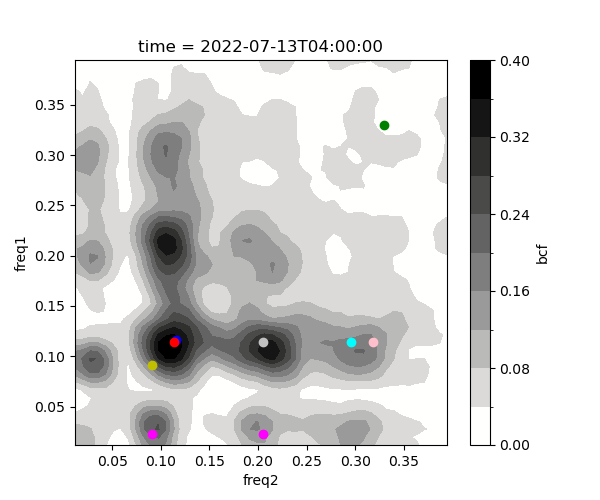

In [12]:
fnb = os.path.join(outdir, 'bicoherence_sig_C6.nc')
dsb = xr.open_dataset(fnb, decode_coords='all')
fns = os.path.join(sig_specdir, 'Asilomar_2022_SSA_Signature_103094_spec_AST_ENU.nc')
dss = xr.open_dataset(fns, decode_coords='all')
ts = pd.Timestamp('2022-07-13 04:00')
# Plot
fig, ax = plt.subplots(figsize=(6,5))
dsb.sel(time=ts, freq1=slice(0,0.4), freq2=slice(0,0.4)).bcf.plot.contourf(
    ax=ax, cmap=cmocean.cm.gray_r, vmin=0, vmax=0.4, levels=np.linspace(0,0.4,11))
# fp
fp = dss.fp.sel(time=ts).item()
ax.scatter(fp, fp, c='b')
# fp swell1
fps1 = dss.fp_swell1.sel(time=ts).item()
ax.scatter(fps1, fps1, c='r')
# fp swell2
fps2 = dss.fp_swell2.sel(time=ts).item()
ax.scatter(fps2, fps2, c='y')
# fp windsea
fpw = dss.fp_windsea.sel(time=ts).item()
ax.scatter(fpw, fpw, c='g')
# subharm
fsub = abs(fps1 - fps2)
ax.scatter(fps2, fsub, c='magenta')
# superharm 2+3
fsup2 = abs(fps1 + fps2)
ax.scatter(fsup2, fps1, c='silver')
ax.scatter(fsup2, fsub, c='magenta')
fsup3 = abs(2*fps1 + fps2)
ax.scatter(fsup3, fps1, c='pink')
fsup3 = abs(fps1 + 2*fps2)
ax.scatter(fsup3, fps1, c='cyan')

plt.show()

Squared bicoherence at different harmonics, offshore vs inshore measurements (both Sig & Vec).

In [362]:
# Reample indices for vector dataframes (some missing hours)
df_vec['C2'] = df_vec['C2'].reindex(df_sig['C3'].index, method='ffill')
df_vec['C3'] = df_vec['C3'].reindex(df_sig['C3'].index, method='ffill')
df_vec['C5'] = df_vec['C5'].reindex(df_sig['C3'].index, method='ffill')

fn_fig = os.path.join(figdir, 'bicoh_offshore_vs_inshore.pdf')
# Initialize figure
fig, axes = plt.subplots(figsize=(7.5,4.5), ncols=3, nrows=2, constrained_layout=True)
s = 10 # Marker size
cmap = cmocean.cm.matter_r # colormap
ck = 'kpd' # Values by which to assign colormap
vmin = 0.6
vmax = 1.4
font = 10
# Sig
for i,(ks,kw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    # Swell interactions, marker:o
    x = df_sig['C1'][ks].to_frame()
    y = df_sig['C6'][ks]
    cs1 = axes[0,i].scatter(x=x, y=y, c=df_sig['C1'][ck], vmin=vmin, vmax=vmax, cmap=cmap, marker='o', s=s)
    # Swell / windsea interactions, marker:^
    x = df_sig['C1'][kw].to_frame()
    y = df_sig['C6'][kw]
    axes[0,i].scatter(x=x, y=y, c=df_sig['C1'][ck], vmin=vmin, vmax=vmax, cmap=cmap, marker='^', s=s)
    # Least squares fit, see:
    x = pd.DataFrame(np.concatenate((df_sig['C1'][ks].values, df_sig['C1'][kw].values))).dropna()
    y = pd.DataFrame(np.concatenate((df_sig['C6'][ks].values, df_sig['C6'][kw].values))).dropna()
    rm = (x/y).mean().item() # Mean of ratios
    print(f'Signature mean {ks}-ratio SO/SI: {rm:.2f}')
    # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
    # Force intercept to be 0, see:
    # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
    # model = sm.OLS(y, x.assign(intercept=0), missing='drop')
    #     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
    #     results = model.fit()
    #     b, m = results.params
    # Force intercept to go through zero
    model = smm.RLM(y, x.assign(intercept=0), missing='drop', 
                    M=smm.robust.norms.HuberT())
    results = model.fit()
    m, b = results.params
    # Plot least squares fit
    #     if b < 0:
    #         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
    #     else:
    #         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
    sf = f'$y = {m:.4f}x$' # Regression function
    # axes[0,i].axline(xy1=(0,b), slope=m, color='k', linestyle='-', lw=1)
# Vec
for i,(ks,kw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'],['bp_ws', 'bp2_ws', 'bps_ws'])):
    # Swell interactions, marker:o
    x = df_vec['C2'][ks].to_frame() 
    y = df_vec['C5'][ks]
    cs2 = axes[1,i].scatter(x=x, y=y, c=df_vec['C2'][ck], vmin=vmin, vmax=vmax, cmap=cmap, marker='o', s=s)
    # Swell / windsea interactions, marker:^
    x = df_vec['C2'][kw].to_frame()
    y = df_vec['C5'][kw]
    axes[1,i].scatter(x=x, y=y, c=df_vec['C2'][ck], vmin=vmin, vmax=vmax, cmap=cmap, marker='^', s=s)
    # Least squares fit, combine swell + windsea
    x = np.concatenate((df_vec['C2'][ks].values, df_vec['C2'][kw].values))
    y = np.concatenate((df_vec['C5'][ks].values, df_vec['C5'][kw].values))
    # Drop all nans and convert to dataframe
    naninds = np.logical_or(np.isnan(x), np.isnan(y))
    x = pd.DataFrame(x[~naninds])
    y = pd.DataFrame(y[~naninds])
    rm = (x/y).mean().item() # Mean of ratios
    print(f'Vector mean {ks}-ratio VO/VI: {rm:.2f}')
    # Force intercept to go through zero
    model = smm.RLM(y, x.assign(intercept=0), missing='drop', 
                    M=smm.robust.norms.HuberT(),
                    )
    results = model.fit()
    m, b = results.params
    # Plot least squares fit
    sf = f'$y = {m:.4f}x$' # Regression function
    # axes[1,i].axline(xy1=(0,b), slope=m, color='k', linestyle='-', lw=1)

# Colorbars on right
cax1 = axes[0,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb1 = fig.colorbar(cs1, ax=axes[0,-1], cax=cax1, 
                   label=r'$k_\mathrm{p} \, h$ [-]',
                   extend='both',
                   )
cax2 = axes[1,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb2 = fig.colorbar(cs2, ax=axes[1,-1], cax=cax2, 
                   label=r'$k_\mathrm{p} \, h$ [-]',
                   extend='both',
                   )

# Limits Sig
axes[0,0].set_xlim([-0.01,0.41])
axes[0,0].set_ylim([-0.01,0.41])
axes[0,1].set_xlim([-0.01,0.26])
axes[0,1].set_ylim([-0.01,0.26])
axes[0,2].set_xlim([-0.01,0.26])
axes[0,2].set_ylim([-0.01,0.26])
# Limits Vec
axes[1,0].set_xlim([-0.01,0.2+0.01])
axes[1,0].set_ylim([-0.01,0.2+0.01])
axes[1,0].set_xticks([0, 0.1, 0.2])
axes[1,0].set_yticks([0, 0.1, 0.2])
axes[1,1].set_xlim([-0.0025,0.1+0.0025])
axes[1,1].set_ylim([-0.0025,0.1+0.0025])
axes[1,1].set_xticks([0, 0.05, 0.1])
axes[1,1].set_yticks([0, 0.05, 0.1])
axes[1,2].set_xlim([-0.0025,0.1+0.0025])
axes[1,2].set_ylim([-0.0025,0.1+0.0025])
axes[1,2].set_xticks([0, 0.05, 0.1])
axes[1,2].set_yticks([0, 0.05, 0.1])
# Labels
axes[0,0].set_xlabel(r'$b^2(f_\mathrm{p},f_\mathrm{p})$ (SO)', fontsize=font)
axes[0,0].set_ylabel(r'$b^2(f_\mathrm{p},f_\mathrm{p})$ (SI)', fontsize=font)
axes[0,1].set_xlabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p,1})$ (SO)', fontsize=font)
axes[0,1].set_ylabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p,1})$ (SI)', fontsize=font)
axes[0,2].set_xlabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p,1})$ (SO)', fontsize=font)
axes[0,2].set_ylabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p,1})$ (SI)', fontsize=font)
axes[1,0].set_xlabel(r'$b^2(f_\mathrm{p},f_\mathrm{p})$ (VO)', fontsize=font)
axes[1,0].set_ylabel(r'$b^2(f_\mathrm{p},f_\mathrm{p})$ (VI)', fontsize=font)
axes[1,1].set_xlabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p,1})$ (VO)', fontsize=font)
axes[1,1].set_ylabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p,1})$ (VI)', fontsize=font)
axes[1,2].set_xlabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p,1})$ (VO)', fontsize=font)
axes[1,2].set_ylabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p,1})$ (VI)', fontsize=font)


# Shared axis params
ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', ]
for i,ax in enumerate(axes.flat):
    # ax.set_aspect('equal')
    # 1:1 line
    ax.axline(xy1=(0,0), slope=1, color='k', linestyle='--', lw=1)
    ax.grid(alpha=0.5, lw=0.5)
    ax.annotate(ann[i], color='k', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12)

if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()
# plt.close()

Signature mean bp_sw-ratio SO/SI: 0.92
Signature mean bp2_sw-ratio SO/SI: 1.15
Signature mean bps_sw-ratio SO/SI: 1.01
Vector mean bp_sw-ratio VO/VI: 1.72
Vector mean bp2_sw-ratio VO/VI: 3.18
Vector mean bps_sw-ratio VO/VI: 1.29


Histograms of squared bicoherence values at different harmonics, Sig & Vec.

In [363]:
# Init filename and figure
fn_fig = os.path.join(figdir, 'bicoh_histograms.pdf')
fig, axes = plt.subplots(figsize=(7.5,5.25), ncols=3, nrows=2, sharey=True, constrained_layout=True)

# Signatures
for i,(ks,kw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'], ['bp_ws', 'bp2_ws', 'bps_ws'])):
    # Least squares fit, combine swell + windsea
    x = np.concatenate((df_sig['C1'][ks].values, df_sig['C1'][kw].values))
    y = np.concatenate((df_sig['C3'][ks].values, df_sig['C3'][kw].values))
    z = np.concatenate((df_sig['C6'][ks].values, df_sig['C6'][kw].values))
    # Drop all nans and convert to dataframe
    naninds = np.logical_or(np.isnan(x), np.isnan(y), np.isnan(z))
    x = x[~naninds].squeeze()
    y = y[~naninds].squeeze()
    z = z[~naninds].squeeze()
    if i == 0:
        bins = np.linspace(0, 0.4, 9)
    else:
        bins = np.linspace(0, 0.2, 9)
    xw = np.empty(x.shape)
    xw.fill(1/x.shape[0])
    yw = np.empty(y.shape)
    yw.fill(1/y.shape[0])
    zw = np.empty(z.shape)
    zw.fill(1/z.shape[0])
    axes[0,i].hist([x,y,z], bins=bins, weights=[xw,yw,zw], color=[clss['C1'],clss['C3'],clss['C6']], label=[sig_mids['C1'],sig_mids['C3'],sig_mids['C6']])
# Vectors
for i,(ks,kw) in enumerate(zip(['bp_sw', 'bp2_sw', 'bps_sw'], ['bp_ws', 'bp2_ws', 'bps_ws'])):
    # Least squares fit, combine swell + windsea
    x = np.concatenate((df_vec['C2'][ks].values, df_vec['C2'][kw].values))
    y = np.concatenate((df_vec['C3'][ks].values, df_vec['C3'][kw].values))
    z = np.concatenate((df_vec['C5'][ks].values, df_vec['C5'][kw].values))
    # Drop all nans and convert to dataframe
    naninds = np.logical_or(np.isnan(x), np.isnan(y), np.isnan(z))
    x = x[~naninds].squeeze()
    y = y[~naninds].squeeze()
    z = z[~naninds].squeeze()
    if i == 0:
        bins = np.linspace(0, 0.2, 9)
    else:
        bins = np.linspace(0, 0.04, 9)
    xw = np.empty(x.shape)
    xw.fill(1/x.shape[0])
    yw = np.empty(y.shape)
    yw.fill(1/y.shape[0])
    zw = np.empty(z.shape)
    zw.fill(1/z.shape[0])
    axes[1,i].hist([x,y,z], bins=bins, weights=[xw,yw,zw], color=[clsv['C2'],clsv['C3'],clsv['C5']], label=[vec_mids['C2'],vec_mids['C3'],vec_mids['C5']])

# Shared axis params
ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', ]
for i,ax in enumerate(axes.flat):
    ax.grid(alpha=0.5, lw=0.5)
    if i == 0 or i == 3:
        ax.annotate(ann[i], color='k', xy=(0.85, 0.8), xycoords='axes fraction', fontsize=12)
    else:
        ax.annotate(ann[i], color='k', xy=(0.85, 0.9), xycoords='axes fraction', fontsize=12)

axes[0,0].legend(fontsize=8, ncols=3, loc='upper center')
axes[1,0].legend(fontsize=8, ncols=3, loc='upper center')

# Labels
axes[0,0].set_ylabel('pdf')
axes[1,0].set_ylabel('pdf')
axes[0,0].set_xlabel(r'$b^2(f_\mathrm{p}, f_\mathrm{p})$ ($\zeta$)')
axes[0,1].set_xlabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p})$ ($\zeta$)')
axes[0,2].set_xlabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p})$ ($\zeta$)')
axes[1,0].set_xlabel(r'$b^2(f_\mathrm{p}, f_\mathrm{p})$ ($u_\mathrm{rms}$)')
axes[1,1].set_xlabel(r'$b^2(f_\mathrm{p,1}+f_\mathrm{p,2}, f_\mathrm{p})$ ($u_\mathrm{rms}$)')
axes[1,2].set_xlabel(r'$b^2(f_\mathrm{p,1}-f_\mathrm{p,2}, f_\mathrm{p})$ ($u_\mathrm{rms}$)')

if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()

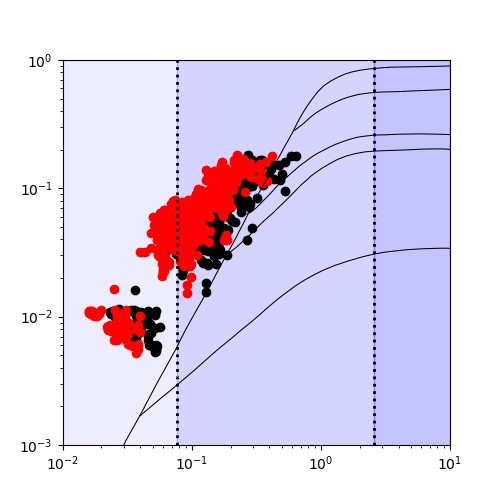

In [61]:
from scipy.signal import savgol_filter
lmdir = os.path.join(figdir, 'le_mehaute', 'NonLinearWaveSolver', 'NonLinearWaveSolver')
x1 = loadmat(os.path.join(lmdir, 'xdata1.mat'))['x1'].squeeze()
x2 = loadmat(os.path.join(lmdir, 'xdata2.mat'))['x2'].squeeze()
x3 = loadmat(os.path.join(lmdir, 'xdata3.mat'))['x3'].squeeze()
x4 = loadmat(os.path.join(lmdir, 'xdata4.mat'))['x4'].squeeze()
x6 = loadmat(os.path.join(lmdir, 'xdata6.mat'))['x6'].squeeze()
y1 = loadmat(os.path.join(lmdir, 'ydata1.mat'))['y1'].squeeze()
y2 = loadmat(os.path.join(lmdir, 'ydata2.mat'))['y2'].squeeze()
y3 = loadmat(os.path.join(lmdir, 'ydata3.mat'))['y3'].squeeze()
y4 = loadmat(os.path.join(lmdir, 'ydata4.mat'))['y4'].squeeze()
y6 = loadmat(os.path.join(lmdir, 'ydata6.mat'))['y6'].squeeze()

xline1= 0.07757
yline1= 1
xline2= 2.59916
yline2= 1


# Below: defining the areas of the water wave categories
xlinear1 = [0, xline1]
ylinear1= [1, 1]
xlinear2= [xline1, xline2]
ylinear2= [1, 1]
xlinear3= [xline2, 10]
ylinear3= [1, 1]

fig, ax = plt.subplots(figsize=(5,5))
ax.loglog(savgol_filter(x1, 7, 3), savgol_filter(y1, 7, 3), c='k', lw=0.75)
ax.loglog(savgol_filter(x2, 7, 3), savgol_filter(y2, 7, 3), c='k', lw=0.75)
ax.loglog(savgol_filter(x3, 7, 3), savgol_filter(y3, 7, 3), c='k', lw=0.75)
ax.loglog(savgol_filter(x4, 7, 3), savgol_filter(y4, 7, 3), c='k', lw=0.75)
ax.loglog(savgol_filter(x6, 7, 3), savgol_filter(y6, 7, 3), c='k', lw=0.75)

ax.loglog([xline1,xline1],[0.001,1], c='k', ls=':', lw=2)
ax.loglog([xline2,xline2],[0.001,1], c='k', ls=':', lw=2)

ax.fill_between(xlinear1, ylinear1, color='b', alpha=0.07,)
ax.fill_between(xlinear2, ylinear2, color='b', alpha=0.17,)
ax.fill_between(xlinear3, ylinear3, color='b', alpha=0.23,)

ax.set_xlim([0.01, 10])
ax.set_ylim([0.001, 1])

# Plot measurements from SO & SM
fn_c1 = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103088_spec_AST_ENU.nc')
dss_c1 = xr.open_dataset(fn_c1, decode_coords='all')
fn_c3 = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103094_spec_AST_ENU.nc')
dss_c3 = xr.open_dataset(fn_c3, decode_coords='all')

y = (2*np.sqrt(2)*dss_c1.Hm0 / ((1/dss_c1.fp)**2))
x = (dss_c1.depth_loc / ((1/dss_c1.fp)**2))
ax.scatter(x, y, c='k')
y = (2*np.sqrt(2)*dss_c3.Hm0 / ((1/dss_c3.fp)**2))
x = (dss_c3.depth_loc / ((1/dss_c3.fp)**2))
ax.scatter(x, y, c='r')

plt.show()

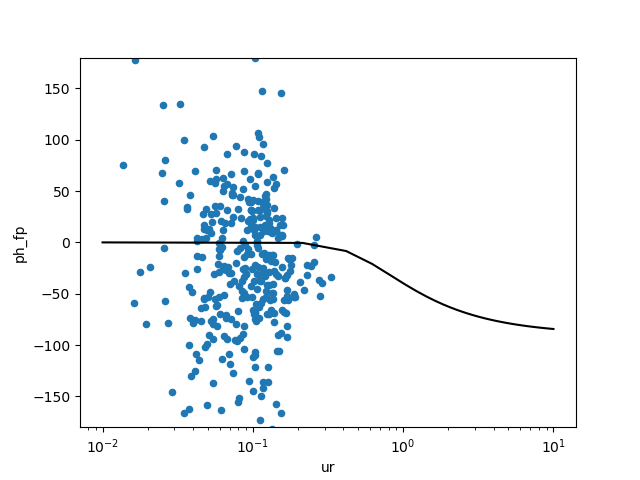

In [120]:
fn = os.path.join(outdir, 'bicoherence_biphase_sig_C6.nc')
dsb = xr.open_dataset(fn, decode_coords='all')
fig, ax = plt.subplots()
df_sig['C3'].plot.scatter(x='ur', y='ph_fp', ax=ax)
ax.set_xscale('log')
# np.rad2deg(dsb.bp.sel(time='2022-07-13 04:00')).plot.pcolormesh(ax=ax)
delta = 0.63
urs = np.linspace(1e-2, 10)
beta_fp_pred = -90 + 90*np.tanh(delta / urs)
ax.plot(urs, beta_fp_pred, c='k')

# ax.set_xlim([0,0.4])
ax.set_ylim([-180, 180])
plt.show()

  0%|          | 0/637 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/673 [00:00<?, ?it/s]

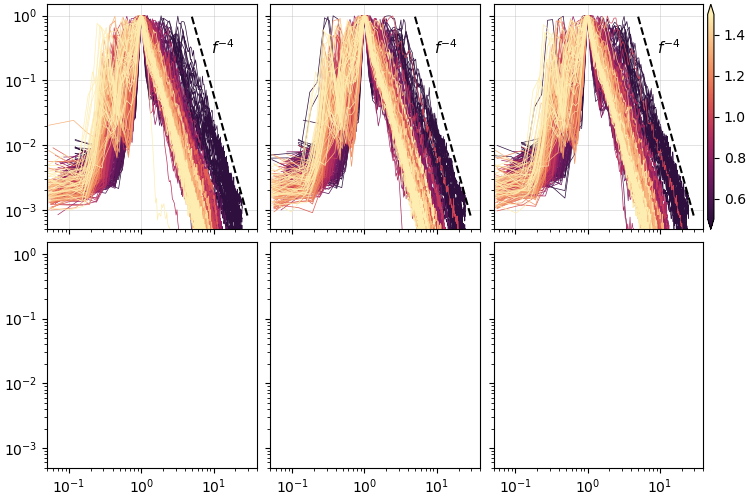

In [173]:
import matplotlib as mpl
# normalize the values. Values between 0 and 10 will be
# normalized to values from 0 and 1.
vmin = 0.5
vmax = 1.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)
# choose an appropriate colormap
cmap = cmocean.cm.matter_r

# Read spectrum nc file for offshore Sig (use this for kp*h)
fn_offshore = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103088_spec_AST_ENU.nc')
dss_offshore = xr.open_dataset(fn_offshore, decode_coords='all')

# Init figure
fig, axes = plt.subplots(figsize=(7.5,5), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
# Normalize spectra and plot with kp*h as color scale
for i,(mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    # Read Sig spectrum nc file
    fn = os.path.join(sig_specdir, f'Asilomar_2022_SSA_Signature_{ser}_spec_AST_ENU.nc')
    dss = xr.open_dataset(fn, decode_coords='all')
    specn_list = [] # List for norm. spectra for sorting
    freqn_list = [] # List for norm. freqs for sorting
    kphn_list = [] # List for norm. kp*h values for sorting
    ax = axes[0,i] # Current axis
    for ts in tqdm(dss.time.values):
        if ts < pd.Timestamp('2022-06-27 00:00:00'):
            continue
        if ts >= pd.Timestamp('2022-07-14 11:00:00'):
            continue
        spec = dss.Ezz.sel(time=ts)
        spec_n = (spec / spec.max()).values
        # Normalize frequencies by peak freq
        fp = dss.fp.sel(time=ts).item()
        freq_n = (spec.freq / fp).values
        kph = dss_offshore.kp.sel(time=ts).item() * dss_offshore.depth_loc.sel(time=ts).item()
        # Normalize kph for color scale
        kph_norm = norm(kph)
        # Append to lists
        specn_list.append(spec_n)
        freqn_list.append(freq_n)
        kphn_list.append(kph_norm)
    # Sort spectra by kp*h and plot
    sort_ind = np.argsort(kphn_list)
    specn_list = np.array(specn_list)[sort_ind]
    freqn_list = np.array(freqn_list)[sort_ind]
    kphn_list = np.array(kphn_list)[sort_ind]
    # Plot normalized spectra with kp*h as color 
    for s,f,k in zip(specn_list, freqn_list, kphn_list):
        # Plot spectrum with kph as color scale
        ims = ax.loglog(f, s, color=cmap(k), lw=0.5)
    # Plot f^-4 line
    xf = np.linspace(5,30)
    ax.loglog(xf, 600*xf**(-4), c='k', ls='--')
    # Annotate slope on plot
    ax.annotate(r'$f^{-4}$', color='k', xy=(0.79, 0.76), xycoords='axes fraction', fontsize=11) 
    # Limits etc
    ax.set_ylim([5e-4, 1.5])
    ax.set_xlim([0.05, 40])
    ax.grid(alpha=0.5, lw=0.5)

# Colorbars on right
cax1 = axes[0,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
# cb1 = fig.colorbar(ims, ax=axes[0,-1], cax=cax1, 
#                    label=r'$k_\mathrm{p} \, h$ (SO) [-]',
#                    )
cb1 = mpl.colorbar.ColorbarBase(cax1, cmap=cmap, norm=norm, orientation='vertical', extend='both',
                                label=r'$k_\mathrm{p} \, h$ (SO) [-]')
# cb1.set_ticks([0, 0.5, 1, 5, 10])
# cax2 = axes[1,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
# cb2 = fig.colorbar(imv, ax=axes[1,-1], cax=cax2, 
#                    label=r'$k_\mathrm{p} \, h$ (SO) [-]',
#                    )

plt.show()
# plt.close()


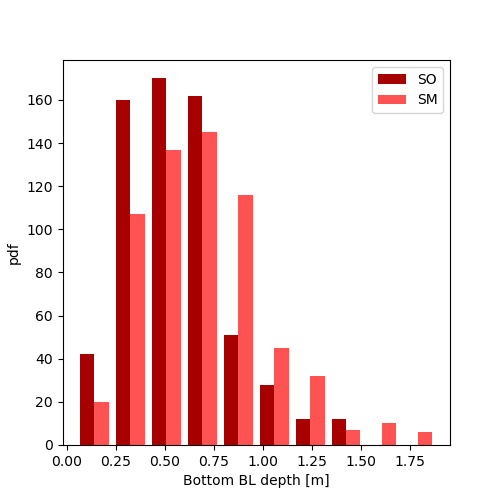

In [127]:
# Histograms of bottom boundary layer depth following Dean and Perlin (1986, C. Eng.)
fn_c1 = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103088_spec_AST_ENU.nc')
dss_c1 = xr.open_dataset(fn_c1, decode_coords='all')
fn_c3 = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_103094_spec_AST_ENU.nc')
dss_c3 = xr.open_dataset(fn_c3, decode_coords='all')

fig, ax = plt.subplots(figsize=(5,5))
# Boundary layer depth for C1
K = 0.4
H = dss_c1.Hm0
k = dss_c1.kp
L = 2*np.pi / k
h = dss_c1.depth_loc
delta_1 = K * (H / L) * h / ((h/L) * np.sinh(k*h))
# Boundary layer depth for C3
H = dss_c3.Hm0
k = dss_c3.kp
L = 2*np.pi / k
h = dss_c3.depth_loc
delta_3 = K * (H / L) * h / ((h/L) * np.sinh(k*h))

# delta_1.plot.hist(ax=ax, label='C1')
# delta_3.plot.hist(ax=ax, label='C3')
ax.hist([delta_1, delta_3], color=[clss['C1'], clss['C3']], label=[sig_mids['C1'], sig_mids['C3']])

ax.legend()
ax.set_xlabel('Bottom BL depth [m]')
ax.set_ylabel('pdf')

plt.show()
